In [18]:
import transformers as hug
import tensorflow as tf
import pandas as pd
import warnings
import os

from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

warnings.filterwarnings("ignore")
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'



In [19]:
tf.config.list_physical_devices('GPU') 

[]

In [ ]:
%matplotlib inline
sns.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

In [20]:
def pre_process_input_data(filepath='./data/tweets.csv',encoding='cp1252'): #Change encoding if not on windows
    tweets = pd.read_csv(filepath,encoding=encoding,header=None)
    tweets.columns = ['target','id','date','flag','username','text'] #Change column names to things that make sense
    tweets = tweets.drop(columns=['id','date','flag','username']) #Remove unneeded columns from memory

    tweets = tweets.replace({'target':{0:0,4:1}}) #Dataset has only 0=negative sent, 4=positive sent, remappping to 0,1 respectivly
    return tweets

<Axes: >

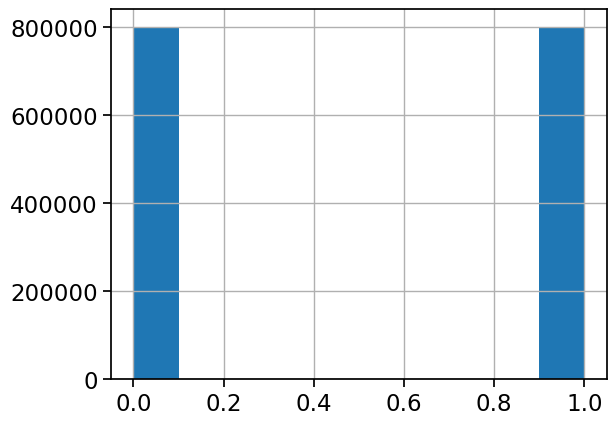

In [21]:
input_data = pre_process_input_data(filepath= "../data/tweets.csv") #Change this to the filepath of the tweets file

input_data['target'].hist()
# input_data.visualize()

## HuggingFace Transformer
<hr>

In [22]:
from transformers import BertTokenizer, TFBertModel
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased')
MODEL = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<Axes: >

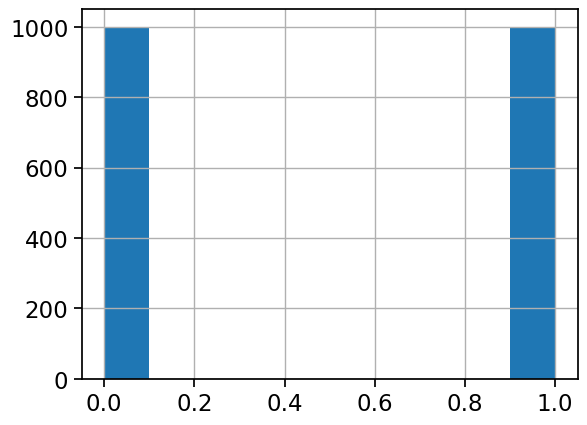

In [30]:
num_samples = 1000
subset = input_data.iloc[:num_samples]
subset = pd.concat([subset,input_data.iloc[-1 * num_samples:]])

# subset = input_data

subset['target'].hist()

In [31]:

# tens,attention = convert_to_encoded("Hello World I am")
def convert_df_to_encoded(df,text_col='text',model=MODEL,tokenizer=TOKENIZER,batch_size=500):

    batches = [(i,min(i+batch_size,len(df))) for i in range(0,len(df),batch_size)] #Split into smaller chunks
    _df = pd.DataFrame()
    max_twt_len = np.max([len(v) for v in df[text_col]])
    print(max_twt_len)
    for lower,upper in tqdm(batches):
        chunk = df.iloc[lower:upper]
        features = tokenizer(chunk[text_col].values.tolist(),padding='max_length', truncation=True, return_tensors='tf',max_length=max_twt_len)
        features = model(**features).last_hidden_state[:,0,:]
        chunk['features'] = features.numpy().tolist()
        _df = pd.concat([_df,chunk])
    return _df
#TODO: PCA compression on vectors down to 250 space for memory reasons


# input_data.sort_values(by='target')

tmp = convert_df_to_encoded(subset)
# tmp = input_data['text'].apply(convert_to_encoded)

157


  0%|          | 0/4 [00:00<?, ?it/s]

#### PCA


In [32]:
x = np.array([x for x in tmp['features']])

In [33]:
x.shape

(2000, 768)

In [34]:
from sklearn.model_selection import train_test_split
vectors = x
targets = tmp['target']
labels = tmp['text']

train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [35]:
train_vectors, val_vectors, train_targets, val_targets, train_labels,val_labels = \
    train_test_split(train_vectors,train_targets,train_labels,test_size = 0.2, random_state=0)

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
train_vectors = pca.fit_transform(train_vectors)
val_vectors = pca.transform(val_vectors)
test_vectors = pca.transform(test_vectors)


In [37]:
print(f"""
Train Vector Shape: {train_vectors.shape}
Validation Vector Shape: {val_vectors.shape}
Test Vector Shape: {test_vectors.shape}
"""
     )


Train Vector Shape: (1440, 300)
Validation Vector Shape: (360, 300)
Test Vector Shape: (200, 300)



In [38]:
classifier = SGDClassifier(loss='log_loss', random_state=0, max_iter=500)
classifier.fit(train_vectors, train_targets)

SGDClassifier(loss='log_loss', max_iter=500, random_state=0)

In [39]:
accuracy_score(classifier.predict(test_vectors), test_targets)

0.695

In [40]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input, Dropout, Embedding

In [41]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.layers import Layer
import tensorflow as tf

In [42]:
#two layer perceptron
def generateNetwork():
    model = Sequential()
    #embedding layer 
    model.add(tf.keras.Input(shape=(300,)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1,activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-3,
    )
    callbacks = []
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001)) #Early stop
    return model, callbacks
mdl,callbacks = generateNetwork()

In [116]:
# 2 Layer CNN

def cnn_seq_noGlove():
        #ensure the input is the 300 dim vector
        sequence_input = Input(shape=(300,1), dtype='float32')
        x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(sequence_input)
        x = MaxPooling1D(5)(x)
        x = Dropout(0.2)(x)

        x = Flatten()(x)
        x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
        preds = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

        model = Model(sequence_input, preds)
        callbacksCNN = []
        model.compile(loss='binary_crossentropy', 
                optimizer='rmsprop',
                metrics=['acc'])
        
        callbacksCNN.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001)) #Early stop
        return model, callbacks

cnnMdl,callbacksCNN = cnn_seq_noGlove()

In [71]:
def generatSimpleRecurrentNetwork(return_callbacks = True):
    RNN_STATESIZE = 100

    rnns = []
    input_holder = tf.keras.Input(shape=(300,1))
    x = layers.SimpleRNN(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(input_holder)
    #use a different activation function
    x = layers.Dense(1, activation='relu')(x)
    simple_RNN = Model(inputs=input_holder,outputs=x)

    opt = Adam(lr=0.0001, epsilon=0.0001, clipnorm=1.0)

    callbacks = []
    simple_RNN.compile(loss='binary_crossentropy', 
              optimizer= opt, 
              metrics=['accuracy'])

    #logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    # callbacks.append(tensorboard_callback)

    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001)) #Early stop
    if return_callbacks:
        return simple_RNN, callbacks
    else:
        return simple_RNN
    
simpleRNN,callbacksRNN = generatSimpleRecurrentNetwork()

In [117]:
cnnMdl.fit(train_vectors,train_targets,epochs=100,validation_data=(val_vectors,val_targets),callbacks=callbacks)

Epoch 1/100
45/45 [==============================] - 1s 6ms/step - loss: 1.7926 - acc: 0.5174 - val_loss: 1.2634 - val_acc: 0.4917
Epoch 2/100
45/45 [==============================] - 0s 5ms/step - loss: 1.1121 - acc: 0.4993 - val_loss: 0.7700 - val_acc: 0.5417
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 0.8692 - acc: 0.5653 - val_loss: 0.8181 - val_acc: 0.5361
Epoch 4/100
45/45 [==============================] - 0s 5ms/step - loss: 0.7856 - acc: 0.6035 - val_loss: 0.7842 - val_acc: 0.5389
Epoch 5/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6888 - acc: 0.6500 - val_loss: 0.6128 - val_acc: 0.6806
Epoch 6/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6575 - acc: 0.6583 - val_loss: 0.5904 - val_acc: 0.6833
Epoch 7/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6189 - acc: 0.6597 - val_loss: 0.6307 - val_acc: 0.6639
Epoch 8/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6022 - a

In [119]:
#save my model to my data folder
cnnMdl.save('../data/cnn_model.h5')

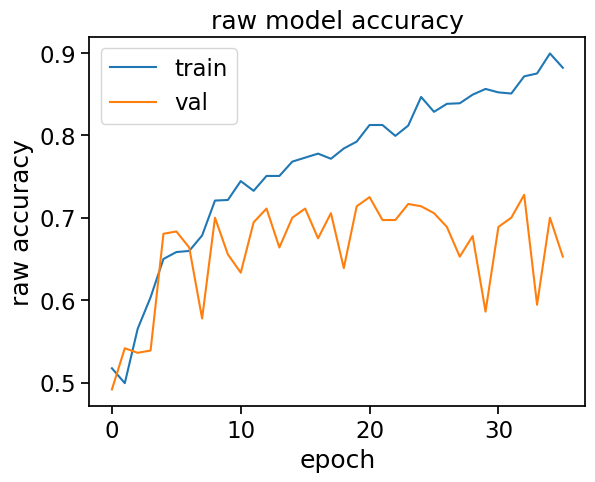

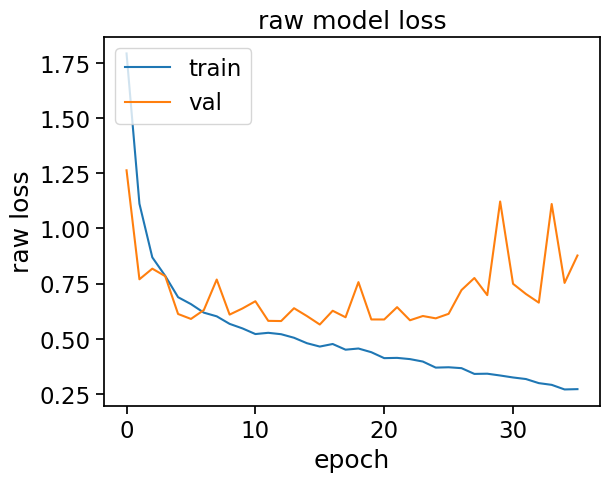

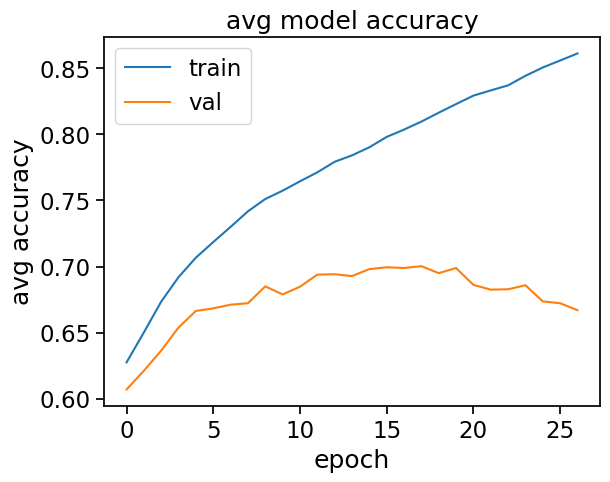

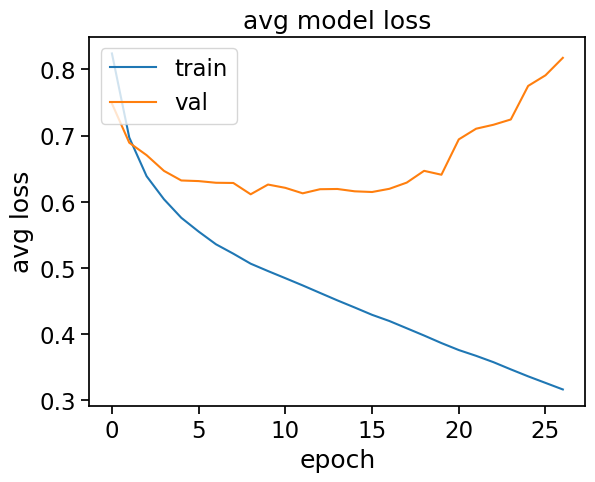

In [118]:
import matplotlib.pyplot as plt
plt.plot(cnnMdl.history.history['acc'])
plt.plot(cnnMdl.history.history['val_acc'])
plt.title('raw model accuracy')
plt.ylabel('raw accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plot the loss and validation loss
plt.plot(cnnMdl.history.history['loss'])
plt.plot(cnnMdl.history.history['val_loss'])
plt.title('raw model loss')
plt.ylabel('raw loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plot the average training and validation accuracy for each epoch for a smoother curve
plt.plot(np.convolve(cnnMdl.history.history['acc'], np.ones(10)/10, mode='valid'))
plt.plot(np.convolve(cnnMdl.history.history['val_acc'], np.ones(10)/10, mode='valid'))
plt.title('avg model accuracy')
plt.ylabel('avg accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plot the average training and validation loss for each epoch for a smoother curve
plt.plot(np.convolve(cnnMdl.history.history['loss'], np.ones(10)/10, mode='valid'))
plt.plot(np.convolve(cnnMdl.history.history['val_loss'], np.ones(10)/10, mode='valid'))
plt.title('avg model loss')
plt.ylabel('avg loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [54]:
mdl.output_shape


(None, 1)

In [64]:
cnnMdl.output_shape

(None, 1)

In [72]:
simpleRNN.output_shape

(None, 1)

In [73]:
simpleRNN.fit(train_vectors,train_targets,validation_data=(val_vectors,val_targets),epochs=100,callbacks=callbacksRNN)

Epoch 1/100
45/45 [==============================] - 2s 32ms/step - loss: 4.0502 - accuracy: 0.5007 - val_loss: 0.8791 - val_accuracy: 0.4444
Epoch 2/100
45/45 [==============================] - 1s 29ms/step - loss: 3.2524 - accuracy: 0.5014 - val_loss: 7.0558 - val_accuracy: 0.5083
Epoch 3/100
45/45 [==============================] - 1s 29ms/step - loss: 2.6531 - accuracy: 0.5236 - val_loss: 7.4975 - val_accuracy: 0.5083
Epoch 4/100
45/45 [==============================] - 1s 29ms/step - loss: 2.4069 - accuracy: 0.4993 - val_loss: 0.8440 - val_accuracy: 0.5694
Epoch 5/100
45/45 [==============================] - 1s 29ms/step - loss: 2.3438 - accuracy: 0.4764 - val_loss: 0.8455 - val_accuracy: 0.5306
Epoch 6/100
45/45 [==============================] - 1s 29ms/step - loss: 2.1680 - accuracy: 0.5000 - val_loss: 0.8076 - val_accuracy: 0.4917
Epoch 7/100
45/45 [==============================] - 1s 30ms/step - loss: 1.4155 - accuracy: 0.4993 - val_loss: 0.7329 - val_accuracy: 0.4556
Epoch 

In [80]:
mdl.fit(train_vectors,train_targets,epochs=200,validation_data=(val_vectors,val_targets),callbacks=callbacks)


Epoch 1/200
45/45 [==============================] - 0s 1ms/step - loss: 0.0572 - accuracy: 0.9889 - val_loss: 0.6824 - val_accuracy: 0.7833
Epoch 2/200
45/45 [==============================] - 0s 693us/step - loss: 0.0605 - accuracy: 0.9875 - val_loss: 0.6860 - val_accuracy: 0.7806
Epoch 3/200
45/45 [==============================] - 0s 731us/step - loss: 0.0532 - accuracy: 0.9910 - val_loss: 0.7017 - val_accuracy: 0.7778
Epoch 4/200
45/45 [==============================] - 0s 720us/step - loss: 0.0550 - accuracy: 0.9896 - val_loss: 0.7122 - val_accuracy: 0.7833
Epoch 5/200
45/45 [==============================] - 0s 702us/step - loss: 0.0452 - accuracy: 0.9924 - val_loss: 0.7181 - val_accuracy: 0.7806
Epoch 6/200
45/45 [==============================] - 0s 685us/step - loss: 0.0476 - accuracy: 0.9896 - val_loss: 0.7283 - val_accuracy: 0.7750
Epoch 7/200
45/45 [==============================] - 0s 688us/step - loss: 0.0494 - accuracy: 0.9924 - val_loss: 0.7224 - val_accuracy: 0.7778
E

In [ ]:
# accuracy_score(mdl.predict(test_vectors),test_targets)
mdl.evaluate(test_vectors,test_targets)

In [ ]:
mdl.metrics_names

In [ ]:
res = mdl.predict(test_vectors)

In [ ]:
viewer = pd.DataFrame({'predict':res.flatten(),'target':test_targets,'sentence':test_labels})

In [ ]:
pd.set_option('max_colwidth', 400)
viewer['diff'] = abs(viewer['predict'] - viewer['target'])
viewer.sort_values(by='diff').tail(30)

In [ ]:
input_data.iloc[0:30]

In [ ]:
input_data.iloc[-30:]

In [ ]:
#Stolen From Josh SYlvester
# def make_neural_net_no_sentiment():
#     # Create the model
#     model = keras.Sequential([
#         layers.Dense(units=128, activation='relu'),
#         layers.Dense(units=64, activation='relu'),
#         layers.Dense(units=1, activation='sigmoid')
#     ])

#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                                 patience=4, min_lr=0.000001, verbose=1)
#     early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001)

#     callbacks = [early_stop, reduce_lr]
#     optimizer = tf.keras.optimizers.Adam(
#         learning_rate=1e-3,
#     )

#     # Compile the model
#     model.compile(optimizer=optimizer,
#                 loss='binary_crossentropy',
#                 metrics=['accuracy'])

#     return model, callbacks